In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
!pip install tensorflow opencv-python matplotlib gradio numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 77.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.9 MB/s eta 0:00:00


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import gradio as gr
import cv2

In [1]:
!unzip /kaggle/input/brain-tumor-mri-dataset/archive.zip -d /kaggle/working/dataset

unzip:  cannot find or open /kaggle/input/brain-tumor-mri-dataset/archive.zip, /kaggle/input/brain-tumor-mri-dataset/archive.zip.zip or /kaggle/input/brain-tumor-mri-dataset/archive.zip.ZIP.


In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop]
)

Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.8338 - loss: 0.4317 - val_accuracy: 0.7599 - val_loss: 0.6608
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.8651 - loss: 0.3710 - val_accuracy: 0.7695 - val_loss: 0.6721
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.8763 - loss: 0.3342 - val_accuracy: 0.8019 - val_loss: 0.6467
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.8702 - loss: 0.3362 - val_accuracy: 0.7599 - val_loss: 0.6414
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 423s 3s/step - accuracy: 0.8873 - loss: 0.2848 - val_accuracy: 0.7914 - val_loss: 0.5730


41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 659ms/step - accuracy: 0.2512 - loss: 1.3888
Test Accuracy: 25.17%


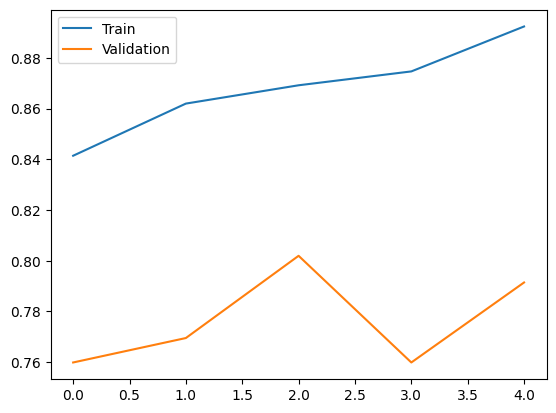

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f'Test Accuracy: {acc*100:.2f}%')

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [36]:
model.save('brain_tumor_model.h5')

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 1023, in predict
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 2103, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1650, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run

Created dataset file at: .gradio/flagged/dataset1.csv


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 2103, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1650, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

In [66]:
def predict_tumor(img):
    classes = ['glioma', 'meningioma', 'pituitary', 'notumor']
    img = cv2.resize(img, (224,224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    preds = model.predict(img)[0]
    return {classes[i]: float(preds[i]) for i in range(4)}

interface = gr.Interface(
    fn=predict_tumor,
    inputs=gr.Image(label="Sube una MRI"),
    outputs=gr.Label(num_top_classes=4),
    examples=['/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0011.jpg'],
    title="Clasificador de Tumores Cerebrales"
)

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://63c5e3236c2c628e19.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 2103, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1650, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

In [69]:
def predict_tumor(img):
    classes = ['glioma', 'meningioma', 'pituitary', 'notumor']
    img = cv2.resize(img, (224, 224))  # Requiere cv2 importado
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    preds = model.predict(img)[0]
    return {classes[i]: float(preds[i]) for i in range(4)}

interface = gr.Interface(
    fn=predict_tumor,
    inputs=gr.Image(label="Sube una MRI"),
    outputs=gr.Label(num_top_classes=4),
    examples=['/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0011.jpg'],
    title="Clasificador de Tumores Cerebrales"
)

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7865
* Running on public URL: https://b44f23aa4da7593e11.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
